# Exercise 2: Regularization

## (a) 
Simulate a data set with $n = 100$ observations based on the relationship $Y = \sin(x_1) + \varepsilon$ with noise term $\varepsilon$ following some distribution. Simulate $p=100$ additional covariates $x_2,\ldots,x_{101}$ that are not related to $Y$.

In [ ]:
# if you want to reproduce the results, please install the following packages
!pip install numpy==1.26.4 matplotlib==3.8.4 scikit-learn==1.5.2

In [16]:
import numpy as np 
import matplotlib.pyplot as plt

plt.style.use('ggplot')


np.random.seed(509)

num_points = 100
num_additional_covs = 100

# the reader may find it interesting to play around with the noise amount
noise_amount = 0.1 

X = np.random.randn(num_additional_covs, num_additional_covs + 1)

Y = np.sin(X[:, 0]) + np.random.randn(num_points) * noise_amount
print(f"X shape: {X.shape}\nY shape: {Y.shape}")

X shape: (100, 101)
Y shape: (100,)


let's see the relationship of Y with x_1 and an unrelated covaraite x_2

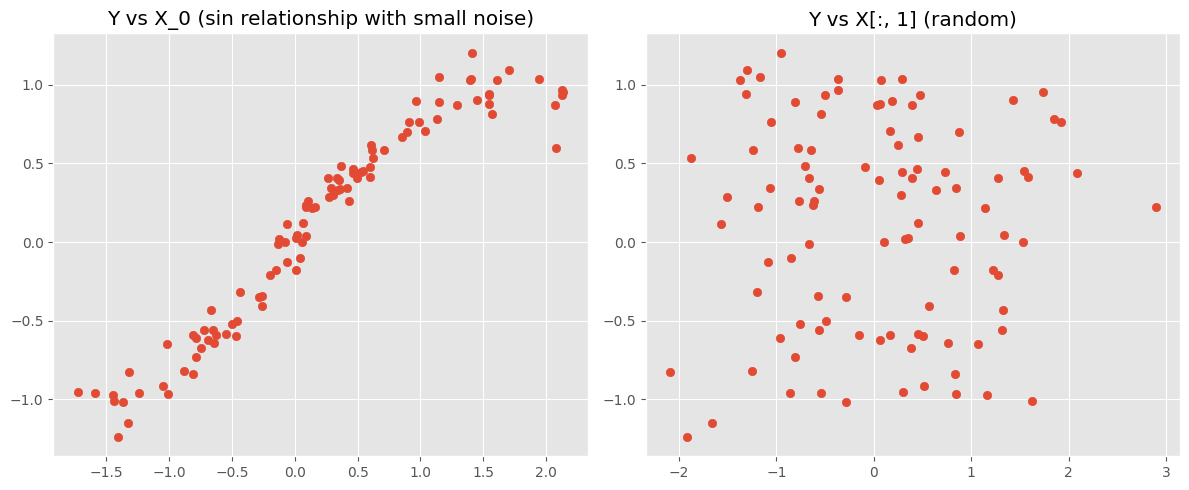

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X[:, 0], Y)
axs[0].set_title('Y vs X_0 (sin relationship with small noise)')

axs[1].scatter(X[:, 1], Y)
axs[1].set_title('Y vs X[:, 1] (random)')

plt.tight_layout()
plt.show()


## (b)
On this data set, use different models (and software packages) of your choice to demonstrate
- overfitting and underfitting;
- $L1$, $L2$ and elastic net regularization;
- the underdetermined problem;
- the bias-variance trade-off;
- early stopping using a simple neural network. %(use a simple neural network as in Exercise 2).


### overfitting and underfitting

Let's try to approximate the (sinusoidal) relationship between Y and x_1 with a simple linear model 
and with a polynomial model of degree 7. 

Also, in order for us to see the effects of under/over-fitting not only usually but also numerically, lets split the data into training and test sets and calculate the training and test errors for each model.

#### Underfitting

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

X_1 = X[:, 0].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_1, Y, 
                                                    test_size=0.2, 
                                                    random_state=509)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Simple Linear Regression")
print(f"Train MSE: {train_mse:.4f}\nTest MSE: {test_mse:.4f}")
print(f"Test error is higher by {((test_mse - train_mse) / train_mse) * 100:.2f}%")

Simple Linear Regression
Train MSE: 0.0313
Test MSE: 0.0595
Test error is higher by 90.07%


visual inspection

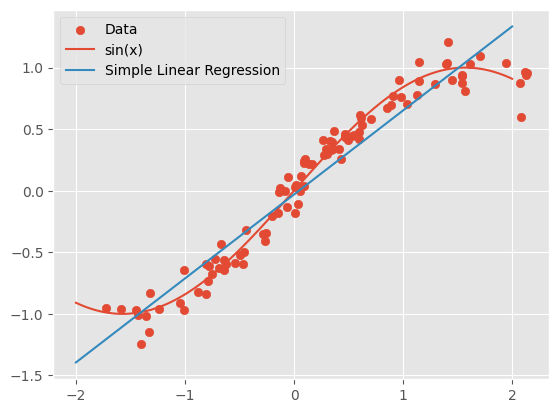

In [ ]:
plt.scatter(X_1, Y, label='Data')

# noiseless DGP
x_vals = np.linspace(-2, 2, 100)
y_vals = np.sin(x_vals)
plt.plot(x_vals, y_vals, label='sin(x)')

# simple linear regression
plt.plot(x_vals, lr.coef_[0] * x_vals + lr.intercept_,
         label='Simple Linear Regression')
plt.legend()

The training error was ~0.03 and test error was ~0.06 which may indicate that the model is overfitting, but we must first ask ourselves whether or not the results on the training set are actually good. 

By plotting the predictions against the actual data we can see that the model is lacks complexity and we should first deal with the underfitting problem.

#### Overfitting

In [70]:
# now let's try polynomial regression
poly_degree = 50
poly = PolynomialFeatures(degree=poly_degree)
poly.fit(X_train) 

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# don't get confused by the model name
# we will be fitting it on the transformed data
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_train_pred = poly_reg.predict(X_train_poly)
y_test_pred = poly_reg.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"\nPolynomial Regression (degree=7)")
print(f"Train MSE: {train_mse:.4f}\nTest MSE: {test_mse:.4f}")
print(f"Test error is higher by {((test_mse - train_mse) / train_mse) * 100:.2f}%")


Polynomial Regression (degree=7)
Train MSE: 0.1385
Test MSE: 145219784.4922
Test error is higher by 104827038582.99%


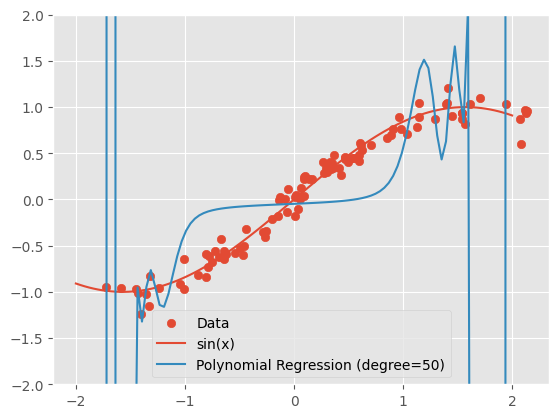

In [71]:
plt.scatter(X_1, Y, label='Data')

# noiseless DGP
x_vals = np.linspace(-2, 2, 100)
y_vals = np.sin(x_vals)
plt.plot(x_vals, y_vals, label='sin(x)')

plt.plot(x_vals, poly_reg.predict(poly.transform(x_vals.reshape(-1, 1))),
            label=f'Polynomial Regression (degree={poly_degree})')

# setting limits to make the plot readable (the model sometimes predicts extreme values)
plt.ylim(-2, 2)


plt.legend()

In this case both from visual inspection and from looking at the training and test errors we can see that the model is extreamly overfitting the data. By looking at the predictions for the points around -1.3 we can nicely see how much the model bends to pass through the training data points, and learns the noise instead of the actual pattern.

The reader may find it interesting to decrease the degree of the polynomial to make the demonstration less extreme, and for degree = 7 you may even notice that the train/test errors alone indicate less overfitting than in the case of simple linear regression.

Also, we encourage the reader to try to find the optimal degree of the polynomial.

##  - $L1$, $L2$ and elastic net regularization;


In [87]:
from sklearn.linear_model import enet_path

def plot_regularization_paths(X, Y, l1_ratio, title):
    alphas, coefs, _ = enet_path(X, Y, l1_ratio=l1_ratio)

    plt.figure()
    for coef in coefs:
        plt.plot(alphas, coef)
    
    plt.xscale("log")
    plt.xlabel("lambda")
    plt.ylabel("Coefficients")
    plt.title(title)
    plt.show()


### L1 (Lasso)
For weak lambda values we can see that the uninformative covariates do have a non zero coefficents, but by increasing the lambda they eventually go to zero.
Although when we penalize the coefficents too strongly the coefficent of $x_1$ also goes to zero, which is not what we want.

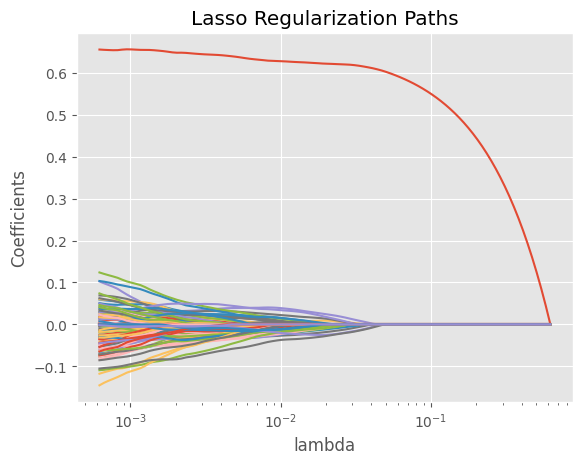

In [91]:
plot_regularization_paths(X, Y, l1_ratio=1, title="Lasso Regularization Paths")	

### L2 (Ridge)
A few differences from the plot above:
- the lambda values are much bigger here (smallest being around $10^4$ instead of $10^{-3}$)
- as a result we also see that the coefficents are much smaller (0.0001 instead of 0.65)

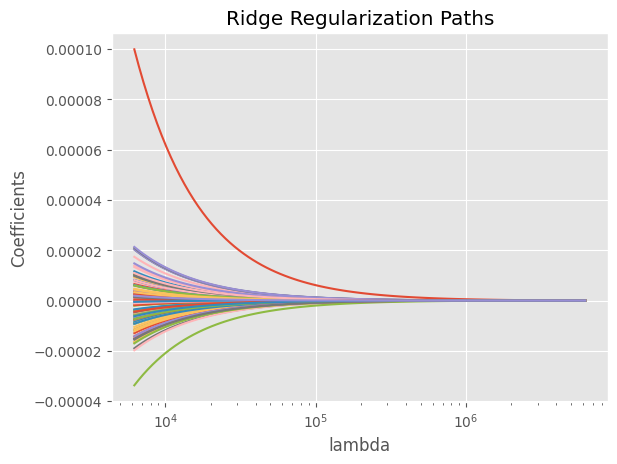

In [92]:
plot_regularization_paths(X, Y, l1_ratio=1e-7, title="Ridge Regularization Paths")	

### Elastic Net (with l1_ratio = 0.3)
this one is somehow inbetween the tho above, lambda's are bigger, but not too big.

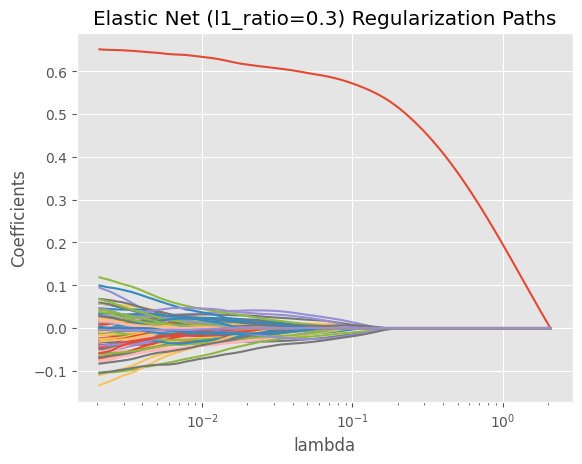

In [93]:
plot_regularization_paths(X, Y, l1_ratio=0.3, title="Elastic Net (l1_ratio=0.3) Regularization Paths")	

The reader may find it interesting to compare the plots for the same lambda values. Or maybe that's something that we can add :) 

### the underdetermined problem
Note:
I struggled a bit to achieve the same result as the R code did, but maybe this type of solution that shows the journey is more useful for the students.


if we have more covariates than observations, then the design matrix is not full rank $\Rightarrow$ the inverse of the design matrix does not exist $\Rightarrow$ we cannot solve the normal equations $\Rightarrow$ we have an underdetermined problem.

In [142]:
print(f"X shape: {X.shape}")

X shape: (100, 101)


we have more covariates than samples, but practically this does not imply that we have a zero determinant

In [143]:
np.linalg.det(X.T @ X)

-3.382261897412918e+143

In [146]:
# let's select even less samples
X = X[:10]
Y = Y[:10]

np.linalg.det(X.T @ X)

0.0

although we see that the determinant is zero, let's try to compute the inverse (although in practice we would instead solve the SLE $X^TX\beta = X^TY$)

In [ ]:
np.linalg.inv(X.T @ X)

array([[-6.14560621e+14,  3.23258780e+14,  2.31422320e+14, ...,
         7.36667699e+13, -4.61268529e+14,  1.40062310e+14],
       [ 7.05436025e+13, -1.48872103e+14, -1.05705693e+14, ...,
         2.62952070e+13, -2.74648424e+13, -9.81077912e+12],
       [-5.05638914e+13,  1.31386044e+14,  4.53445891e+13, ...,
         2.75666330e+14,  2.93356907e+14, -3.74015010e+13],
       ...,
       [-1.06616166e+14, -2.16935255e+13, -2.74450882e+13, ...,
         5.07348591e+13, -1.33374666e+14,  1.40038499e+14],
       [ 3.10643252e+13,  4.88795481e+13, -4.46876100e+13, ...,
         1.04166621e+14,  2.10377348e+14, -6.07121343e+13],
       [-2.03686412e+14, -9.96492008e+13, -1.77264094e+14, ...,
         3.12507118e+14, -5.36625860e+13,  2.98007478e+14]])

We still get an output. If you're curious about the reasoning behind this, please see [this](https://stackoverflow.com/questions/28712734/numpy-possible-for-zero-determinant-matrix-to-be-inverted) stackoverflow post.

In [ ]:
np.linalg.solve(X.T @ X, X.T @ Y) 

-1.7428531505267393

The code above does produce an output, since from the machine perspective the matrix is not singular, because of the floating point approximations. Let's demonstrate the underteermined problem with a manually created example.

In [160]:

X = np.array([
    [1, 1],  
    [1, 1],   
], dtype=float)

# y can be anything
y = np.array([1, 2])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Rank of X:", np.linalg.matrix_rank(X))

try:
    coefs = np.linalg.solve(X.T @ X, X.T @ y)
    print("Direct solution via solve(X^T X, X^T y):", coefs)
except np.linalg.LinAlgError as e:
    print("Failed to invert (X^T X). Error from np.linalg.solve:", e)

X shape: (2, 2)
y shape: (2,)
Rank of X: 1
Failed to invert (X^T X). Error from np.linalg.solve: Singular matrix
